# Training the ResNet-18 with CIFAR-10

This notebook trains the ResNet-18 network with the CIFAR-10 dataset in a deterministic fashion and stores the obtained weights.

### 0. Import libraries and define settings

In [1]:
# import Python packages
import os
import time
import random
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

# import custom Python modules
import utils
from data_loader import DataLoader
from resnet_architecture import ResNet

# allow to automatically update the imported modules
%load_ext autoreload
%autoreload 2


In [2]:
# get cuda or cpu device for training
device = utils.get_device()


Currently using: cuda


In [3]:
# make PyTorch deterministic
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"


[W Context.cpp:70] Warning: torch.use_deterministic_algorithms is in beta, and its design and functionality may change in the future. (function operator())


In [4]:
# define paths and model name
MODEL_PATH = "../../models/"
MODEL_NAME = "baseline_resnet.pth"


### 1. Load and preprocess data

In [5]:
data_loader = DataLoader()
trainset, trainloader = data_loader.load_train_data()
testset, testloader = data_loader.load_test_data()


Files already downloaded and verified
Files already downloaded and verified


### 2. Train the network

In [6]:
# instantiate the network
net = ResNet().to(device)

# define the loss function
criterion = nn.CrossEntropyLoss()

# declare the optimization function
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


In [7]:
# initialize the timer
start = time.time()

# define lists that store train and test accuracy for each epoch
train_acc = []
test_acc = []

for epoch in tqdm(range(0, 2)):

    # initialize number of correct train predictions for the current epoch
    correct_train_total = 0

    net.train()  # Put the network in train mode
    for i, (x_batch, y_batch) in enumerate(trainloader):
        # Move the data to the device that is used
        x_batch, y_batch = x_batch.to(device), y_batch.to(
            device
        )

        # Set all currenly stored gradients to zero
        optimizer.zero_grad()

        y_pred = net(x_batch)

        # compute loss
        loss = criterion(y_pred, y_batch)

        # backpropagate gradients
        loss.backward()

        # apply the optimization step
        optimizer.step()

        # Get the labels with highest output probability
        y_pred_max = torch.argmax(
            y_pred, dim=1
        )

        # Count how many are equal to the true labels
        correct = torch.sum(
            torch.eq(y_pred_max, y_batch)
        ).item()

        # Keep track of how much time has elapsed
        elapsed = time.time() - start

        # Accumulate number of correct predictions
        correct_train_total += correct

        correct_total = 0

    # store train accuracy for current epoch
    train_acc.append(correct_train_total / len(trainset))

    # Put the network in eval mode
    net.eval()

    for i, (x_batch, y_batch) in enumerate(testloader):
        # Move the data to the device that is used
        x_batch, y_batch = x_batch.to(device), y_batch.to(
            device
        )

        # count number of correct predictions
        y_pred = net(x_batch)
        y_pred_max = torch.argmax(y_pred, dim=1)

        correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

    # store test accuracy for current epoch
    test_acc.append(correct_total / len(testset))


100%|██████████| 2/2 [05:04<00:00, 152.43s/it]


### 3. Visualize performance

Train accuracy: 0.67932
Test accuracy: 0.6668


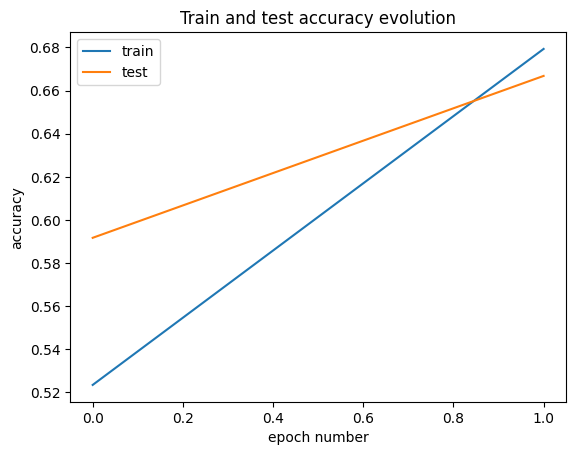

In [8]:
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train", "test"])
plt.xlabel("epoch number")
plt.ylabel("accuracy")
plt.title("Train and test accuracy evolution")

print(f"Train accuracy: {train_acc[-1]}\nTest accuracy: {test_acc[-1]}")


### 4. Store model

In [9]:
# create a folder for storing the models
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# store the trained model
torch.save(net.state_dict(), MODEL_PATH + MODEL_NAME)
